# Data Exploration and Author Prediction


In [1]:
!pip install transformers --quiet

In [2]:
import pandas as pd, matplotlib.pyplot as plt, os
import numpy as np
import sqlite3
import html, re
import seaborn as sns
import itertools
from sentence_transformers import SentenceTransformer
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, f1_score, accuracy_score, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
import nltk
nltk.download('punkt_tab')
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


### Loading the data

In [ ]:
def get_datasets():
    """
    Function to connect to the SQLite database and retrieve the datasets
    """
    conn = sqlite3.connect("../data/database.sqlite")
    content_df = pd.read_sql_query("SELECT * FROM content", conn)
    reviews_df = pd.read_sql_query("SELECT * FROM reviews", conn)
    conn.close()
    return content_df, reviews_df

# Check if the csv files are already downloaded
content_path = "../data/content.csv"
reviews_path = "../data/reviews.csv"
if not os.path.exists(content_path) or not os.path.exists(reviews_path):
  os.makedirs('../data', exist_ok=True)
  if not os.path.exists("database.sqlite"):
    print("Database not found. Please download the database from the link: https://www.kaggle.com/datasets/nolanbconaway/pitchfork-data and place it in the 'data' directory.")
    exit(1)
  else:
    content, reviews = get_datasets()
    content.to_csv(content_path, index=False)
    reviews.to_csv(reviews_path, index=False)
else:
  # Load the datasets from the CSV files
  content = pd.read_csv(content_path)
  reviews = pd.read_csv(reviews_path)
  print("Datasets fetched from directory!")
  # Check if the datasets are empty
  if content.empty or reviews.empty:
    print("The datasets are empty. Please check the CSV files.")
    exit(1)


Datasets fetched from directory!


## Data Cleaning and Preprocessing

We choose the tables we want to work with, general information about the reviews and the content of the reviews, and save the unprocessed data to CSV files

### Checking the reviews data

In [4]:
# Check the information of the reviews table
reviews.info() # There are no null values in the reviews table

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18393 entries, 0 to 18392
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   reviewid        18393 non-null  int64  
 1   title           18391 non-null  object 
 2   artist          18391 non-null  object 
 3   url             18393 non-null  object 
 4   score           18393 non-null  float64
 5   best_new_music  18393 non-null  int64  
 6   author          18393 non-null  object 
 7   author_type     14487 non-null  object 
 8   pub_date        18393 non-null  object 
 9   pub_weekday     18393 non-null  int64  
 10  pub_day         18393 non-null  int64  
 11  pub_month       18393 non-null  int64  
 12  pub_year        18393 non-null  int64  
dtypes: float64(1), int64(6), object(6)
memory usage: 1.8+ MB


In [5]:
# Now we check for duplicates
print("Duplicates in reviews table:")
print(reviews.duplicated().sum())

Duplicates in reviews table:
4


In [6]:
# Let's see the duplicates in the reviews table
reviews[reviews.duplicated(subset=['reviewid'], keep=False)].sort_values(['reviewid'])  # Show duplicates, keep=False to see all

,reviewid,title,artist,url,score,best_new_music,author,author_type,pub_date,pub_weekday,pub_day,pub_month,pub_year
12116,9417,radiodread,easy star all-stars,http://pitchfork.com/reviews/albums/9417-radio...,7.0,0,joe tangari,contributor,2006-10-11,2,11,10,2006
12120,9417,radiodread,easy star all-stars,http://pitchfork.com/reviews/albums/9417-radio...,7.0,0,joe tangari,contributor,2006-10-11,2,11,10,2006
12123,9460,subliminal genocide,xasthur,http://pitchfork.com/reviews/albums/9460-subli...,7.8,0,brandon stosuy,contributor,2006-10-10,1,10,10,2006
12119,9460,subliminal genocide,xasthur,http://pitchfork.com/reviews/albums/9460-subli...,7.8,0,brandon stosuy,contributor,2006-10-10,1,10,10,2006
12122,9499,young machetes,the blood brothers,http://pitchfork.com/reviews/albums/9499-young...,6.2,0,jason crock,NaN,2006-10-10,1,10,10,2006
12118,9499,young machetes,the blood brothers,http://pitchfork.com/reviews/albums/9499-young...,6.2,0,jason crock,NaN,2006-10-10,1,10,10,2006
12117,9505,the dfa remixes: chapter two,various artists,http://pitchfork.com/reviews/albums/9505-the-d...,8.2,0,tim finney,NaN,2006-10-10,1,10,10,2006
12121,9505,the dfa remixes: chapter two,various artists,http://pitchfork.com/reviews/albums/9505-the-d...,8.2,0,tim finney,NaN,2006-10-10,1,10,10,2006


In [7]:
# We drop the duplicates
reviews.drop_duplicates(subset=['reviewid'], keep='first', inplace=True)

reviews.shape # Now we have 18389 entries

(18389, 13)

In [8]:
# We are not interested in the publication dates, author types, or urls, so we drop them
reviews.drop(columns=['author_type', 'best_new_music', 'pub_weekday', 'pub_day', 'pub_month','pub_year', 'author_type', 'url'], inplace=True)
# Check the first few rows of the reviews table
reviews.head()

,reviewid,title,artist,score,author,pub_date
0,22703,mezzanine,massive attack,9.3,nate patrin,2017-01-08
1,22721,prelapsarian,krallice,7.9,zoe camp,2017-01-07
2,22659,all of them naturals,uranium club,7.3,david glickman,2017-01-07
3,22661,first songs,"kleenex, liliput",9.0,jenn pelly,2017-01-06
4,22725,new start,taso,8.1,kevin lozano,2017-01-06


### Checking the content data

In [9]:
content.info() # There are no null values in the content table

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18393 entries, 0 to 18392
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   reviewid  18393 non-null  int64 
 1   content   18383 non-null  object
dtypes: int64(1), object(1)
memory usage: 287.5+ KB


In [10]:
# Now we check for duplicates
print("Duplicates in reviews table:")
print(content.duplicated().sum())

Duplicates in reviews table:
4


In [11]:
# Let's see the duplicates in the content table
content[content.duplicated(subset=['reviewid'], keep=False)].sort_values(['reviewid'])  # Show duplicates, keep=False to see all

,reviewid,content
12116,9417,\r\n A song-for-song reggae cover of Radioh...
12120,9417,\r\n A song-for-song reggae cover of Radioh...
12123,9460,Strange things are a foot in the bowels of hel...
12119,9460,Strange things are a foot in the bowels of hel...
12122,9499,"When we last left our heroes, the Blood Brothe..."
12118,9499,"When we last left our heroes, the Blood Brothe..."
12117,9505,\nOn the one hand it is a largely superfluous ...
12121,9505,\nOn the one hand it is a largely superfluous ...


These are the same duplicates as the ones in the 'reviews' table.

In [12]:
# We drop the duplicates
content.drop_duplicates(subset=['reviewid'], keep='first', inplace=True)

content.shape # Now we have 18389 entries, which is the same as the reviews table

(18389, 2)

### Creating the merged dataframe

In [13]:
# Let's create the final dataset by merging the tables
# But before that, let's check if all the reviewids in the tables match
print("Unique reviewids in reviews:", reviews['reviewid'].nunique())
print("Unique reviewids in content:", content['reviewid'].nunique())

# Ids in reviews
review_reviewids = set(reviews['reviewid'])
# Ids in content, we need all the reviewids to match in both tables
content_reviewids = set(content['reviewid'])


# Checking
if (review_reviewids == content_reviewids):
    print("All reviewids match across reviews and content.")
else:
    print("Mismatch in reviewids across tables. Please check the data.")

Unique reviewids in reviews: 18389
Unique reviewids in content: 18389
All reviewids match across reviews and content.


In [14]:
# Merge the reviews and content tables
merged_full_df = pd.merge(reviews, content, on='reviewid', how='inner')
print("Final dataset shape:", merged_full_df.shape)
print("Final dataset columns:", merged_full_df.columns)

Final dataset shape: (18389, 7)
Final dataset columns: Index(['reviewid', 'title', 'artist', 'score', 'author', 'pub_date',
       'content'],
      dtype='object')


In [15]:
merged_full_df.head()

,reviewid,title,artist,score,author,pub_date,content
0,22703,mezzanine,massive attack,9.3,nate patrin,2017-01-08,"“Trip-hop” eventually became a ’90s punchline,..."
1,22721,prelapsarian,krallice,7.9,zoe camp,2017-01-07,"Eight years, five albums, and two EPs in, the ..."
2,22659,all of them naturals,uranium club,7.3,david glickman,2017-01-07,Minneapolis’ Uranium Club seem to revel in bei...
3,22661,first songs,"kleenex, liliput",9.0,jenn pelly,2017-01-06,Kleenex began with a crash. It transpired one ...
4,22725,new start,taso,8.1,kevin lozano,2017-01-06,It is impossible to consider a given release b...


In [16]:
# Let's see the distribution of numbers of reviews per author
author_counts = merged_full_df['author'].value_counts()
print("Number of unique authors:", author_counts.shape[0])
print("Top 3 authors by number of reviews:")
print(author_counts.head(3))
print("Bottom 3 authors by number of reviews:")
print(author_counts.tail(10)) # We can see that some authors have a lot of reviews, while others have very few
# Note: Dataset contains ~20 multi-author reviews, but they're filtered out when selecting top authors in the next step

Number of unique authors: 432
Top 3 authors by number of reviews:
author
joe tangari           815
stephen m. deusner    725
ian cohen             699
Name: count, dtype: int64
Bottom 3 authors by number of reviews:
author
daniel crumb                     1
oliver lache                     1
chris dahlen & ryan schreiber    1
matt wellins                     1
brandon wall                     1
keith brasel                     1
adam ohler                       1
jared bane                       1
zach hammerman                   1
bruce tiffee                     1
Name: count, dtype: int64


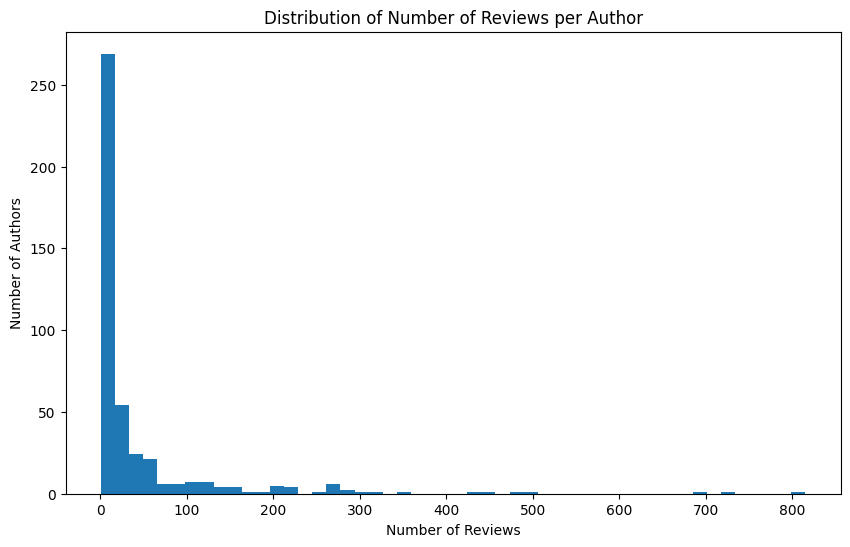

In [17]:
# Let's see the distribution of authors, by number of reviews
plt.figure(figsize=(10, 6))
author_counts.plot(kind='hist', bins=50)
plt.title('Distribution of Number of Reviews per Author')
plt.xlabel('Number of Reviews')
plt.ylabel('Number of Authors')
plt.show()

In [19]:
# Since there are too many authors for our task, and we need a good amount of text data, we define a threshold
# for number of authors to predict the tone of the reviews, let's keep the top 10 authors with the most reviews
top_n_authors = 10
top_authors = author_counts.index[:top_n_authors].tolist()
print("Top", top_n_authors, "authors with the most reviews:")
print(top_authors)

# Filter the dataset to keep only the authors with at least 10 reviews
filtered_df = merged_full_df[merged_full_df['author'].isin(top_authors)].copy()
print("Filtered dataset shape:", filtered_df.shape) # We have 5057 entries, which is over the threshold of 5000 documents

# Save the filtered dataset to a CSV file
filtered_df.to_csv('../data/processed/selected_authors_data.csv', index=False)
print("Filtered dataset saved to 'selected_authors_data.csv'")


Top 10 authors with the most reviews:
['joe tangari', 'stephen m. deusner', 'ian cohen', 'brian howe', 'mark richardson', 'stuart berman', 'marc hogan', 'nate patrin', 'marc masters', 'jayson greene']
Filtered dataset shape: (5057, 7)
Filtered dataset saved to 'selected_authors_data.csv'


### Text Processing

In [20]:
def clean_text(t: str) -> str:
    t = html.unescape(t or '')                # None/NaN safe
    t = re.sub(r'\s+', ' ', t).strip()        # collapse whitespace
    return (t.replace('“','"').replace('”','"')
             .replace('’',"'").replace('‘',"'"))

filtered_df['content'] = filtered_df['content'].astype(str).map(clean_text)

In [21]:
filtered_df.head()

,reviewid,title,artist,score,author,pub_date,content
0,22703,mezzanine,massive attack,9.3,nate patrin,2017-01-08,"""Trip-hop"" eventually became a '90s punchline,..."
9,22724,filthy america its beautiful,the lox,5.3,ian cohen,2017-01-04,There were innumerable cameos at the Bad Boy F...
10,22715,clear sounds/perfetta,harry bertoia,8.0,marc masters,2017-01-04,Lots of drone musicians have been called sound...
24,22713,the wasp factory,ben frost,7.3,brian howe,2016-12-27,How do you stage an opera that mostly takes pl...
25,22705,a very kacey christmas,kacey musgraves,6.8,marc hogan,2016-12-23,Kacey Musgraves continues to follow her arrow....


In [22]:
# Define a proper word counting function
def tokenize_and_count_words(text):
    if not isinstance(text, str):
        return [], 0
    tokens = nltk.tokenize.word_tokenize(text)
    words = [word for word in tokens if word.isalpha()]  # keeps only purely alphabetic tokens
    return len(words)

# Apply the improved word counting function
filtered_df['word_count'] = filtered_df['content'].apply(tokenize_and_count_words)

In [23]:
# quick distribution check
filtered_df['word_count'] = filtered_df['content'].str.split().str.len()
print(filtered_df['word_count'].describe())

count    5057.000000
mean      660.602531
std       242.328700
min         1.000000
25%       497.000000
50%       604.000000
75%       764.000000
max      2657.000000
Name: word_count, dtype: float64


In [24]:
# Check the distribution of word counts, after filtering out empty reviews
more_than_one_word = filtered_df['word_count'] > 1
print(filtered_df[more_than_one_word]['word_count'].describe()) #The distribution is quite normal now, we proceed with dropping the empty reviews

count    5054.000000
mean      660.994064
std       241.866911
min        89.000000
25%       497.000000
50%       604.000000
75%       764.000000
max      2657.000000
Name: word_count, dtype: float64


In [25]:
# We drop the rows with less than 2 words
filtered_df = filtered_df[more_than_one_word].copy()

In [26]:
filtered_df.info() # We have 5054 cleaned reviews for our task

<class 'pandas.core.frame.DataFrame'>
Index: 5054 entries, 0 to 17765
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   reviewid    5054 non-null   int64  
 1   title       5053 non-null   object 
 2   artist      5053 non-null   object 
 3   score       5054 non-null   float64
 4   author      5054 non-null   object 
 5   pub_date    5054 non-null   object 
 6   content     5054 non-null   object 
 7   word_count  5054 non-null   int64  
dtypes: float64(1), int64(2), object(5)
memory usage: 355.4+ KB


In [27]:
dir_ = "../data/processed/preprocessed_data.csv"
filtered_df.to_csv(dir_, index=False)
print(f"final processed data saved to {dir_}")

final processed data saved to data/processed/preprocessed_data.csv


In [28]:
filtered_df.head()

,reviewid,title,artist,score,author,pub_date,content,word_count
0,22703,mezzanine,massive attack,9.3,nate patrin,2017-01-08,"""Trip-hop"" eventually became a '90s punchline,...",1456
9,22724,filthy america its beautiful,the lox,5.3,ian cohen,2017-01-04,There were innumerable cameos at the Bad Boy F...,1020
10,22715,clear sounds/perfetta,harry bertoia,8.0,marc masters,2017-01-04,Lots of drone musicians have been called sound...,514
24,22713,the wasp factory,ben frost,7.3,brian howe,2016-12-27,How do you stage an opera that mostly takes pl...,694
25,22705,a very kacey christmas,kacey musgraves,6.8,marc hogan,2016-12-23,Kacey Musgraves continues to follow her arrow....,824


## Exploratory Data Analysis

### Visual EDA

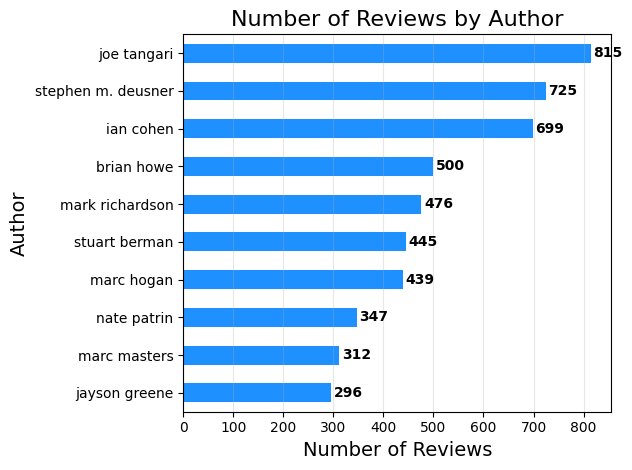


Author review counts:
joe tangari: 815 reviews
stephen m. deusner: 725 reviews
ian cohen: 699 reviews
brian howe: 500 reviews
mark richardson: 476 reviews
stuart berman: 445 reviews
marc hogan: 439 reviews
nate patrin: 347 reviews
marc masters: 312 reviews
jayson greene: 296 reviews


In [29]:
author_counts = filtered_df['author'].value_counts().sort_values(ascending=True)
bars = author_counts.plot(kind='barh', color='dodgerblue')
plt.title('Number of Reviews by Author', fontsize=16)
plt.xlabel('Number of Reviews', fontsize=14)
plt.ylabel('Author', fontsize=14)
plt.grid(axis='x', alpha=0.3)
# Add count labels to the end of each bar
for i, v in enumerate(author_counts):
    plt.text(v + 5, i, str(v), va='center', fontweight='bold')

plt.tight_layout()
plt.show()

# Also print the data for reference
print("\nAuthor review counts:")
for author, count in author_counts.loc[::-1].items():
    print(f"{author}: {count} reviews")

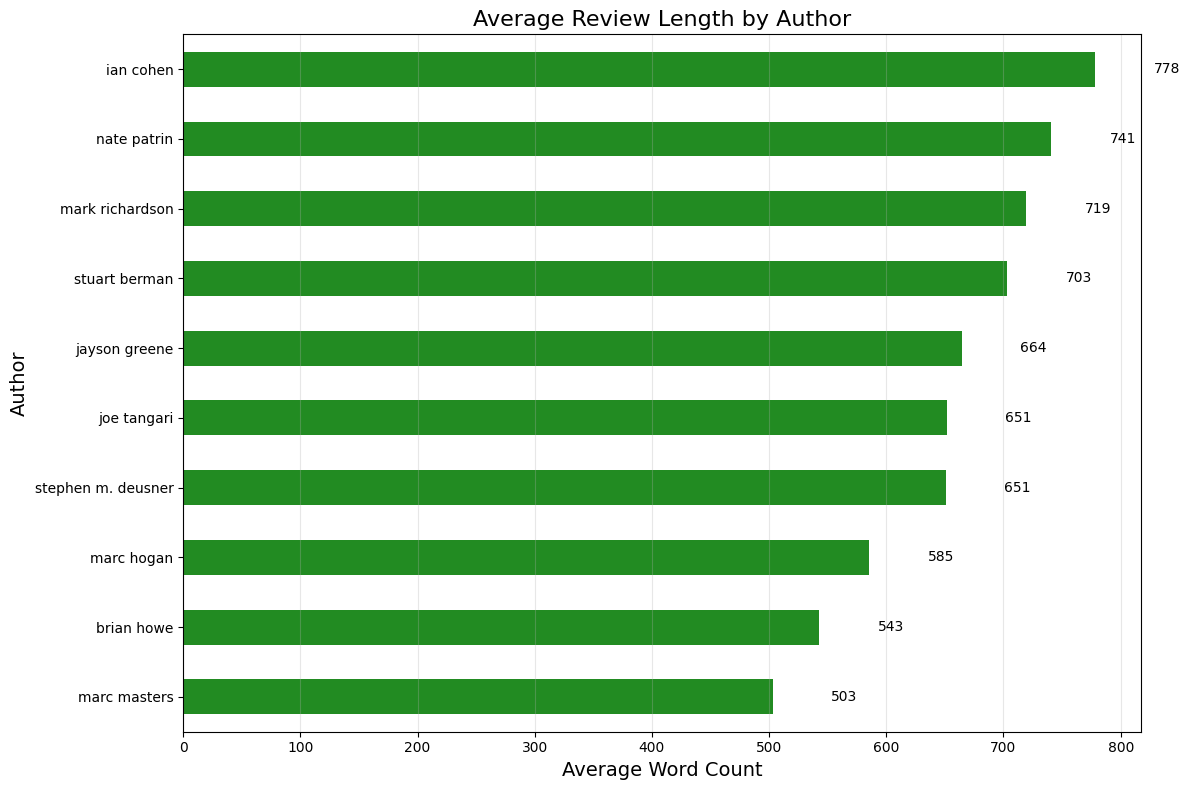

In [30]:
# Calculate average word count by author
avg_lengths = filtered_df.groupby('author')['word_count'].mean().sort_values()

# Plot authors by average review length
plt.figure(figsize=(12, 8))
avg_lengths.plot(kind='barh', color='forestgreen')
plt.title('Average Review Length by Author', fontsize=16)
plt.xlabel('Average Word Count', fontsize=14)
plt.ylabel('Author', fontsize=14)
plt.grid(axis='x', alpha=0.3)

# Add value annotations
for i, v in enumerate(avg_lengths):
    plt.text(v + 50, i, f"{v:.0f}", va='center')

plt.tight_layout()
plt.show()

<ipython-input-31-00da3d609b24>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='score', y='author', data=filtered_df, palette='viridis')


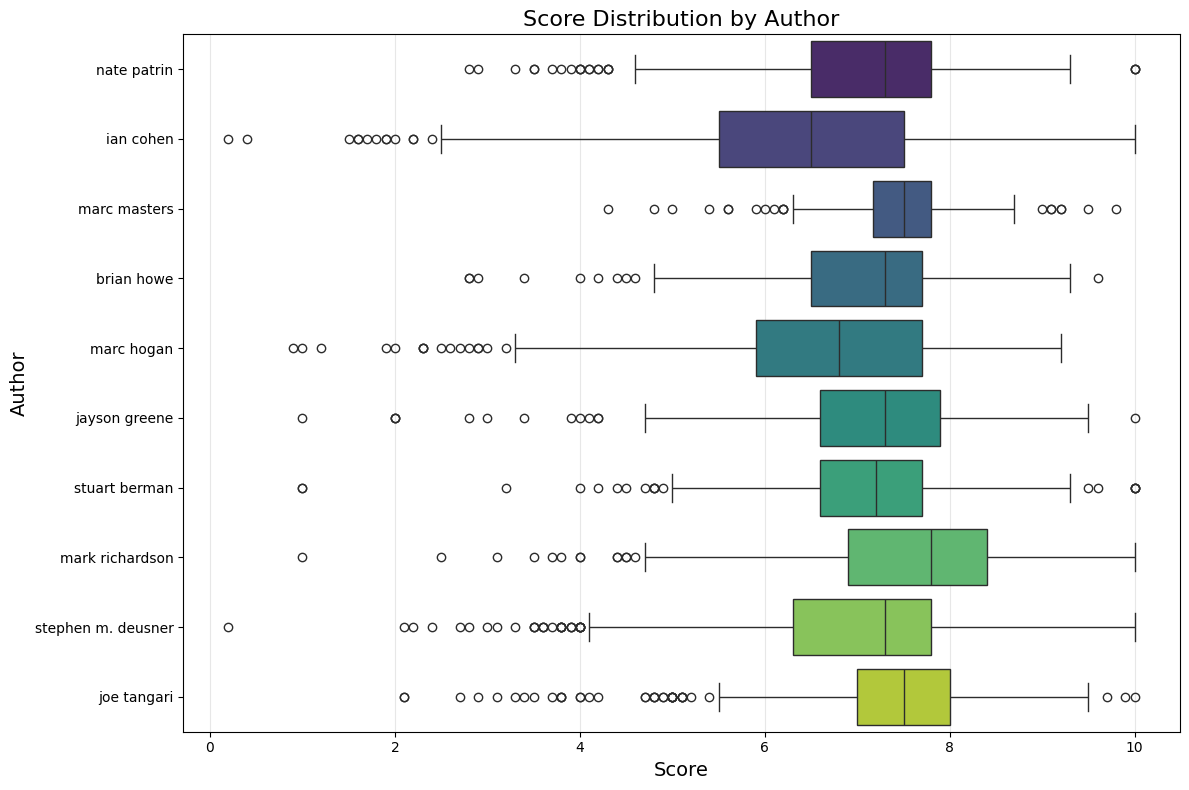

In [31]:
# We create a boxplot showing score distribution by author
plt.figure(figsize=(12, 8))
sns.boxplot(x='score', y='author', data=filtered_df, palette='viridis')
plt.title('Score Distribution by Author', fontsize=16)
plt.xlabel('Score', fontsize=14)
plt.ylabel('Author', fontsize=14)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()


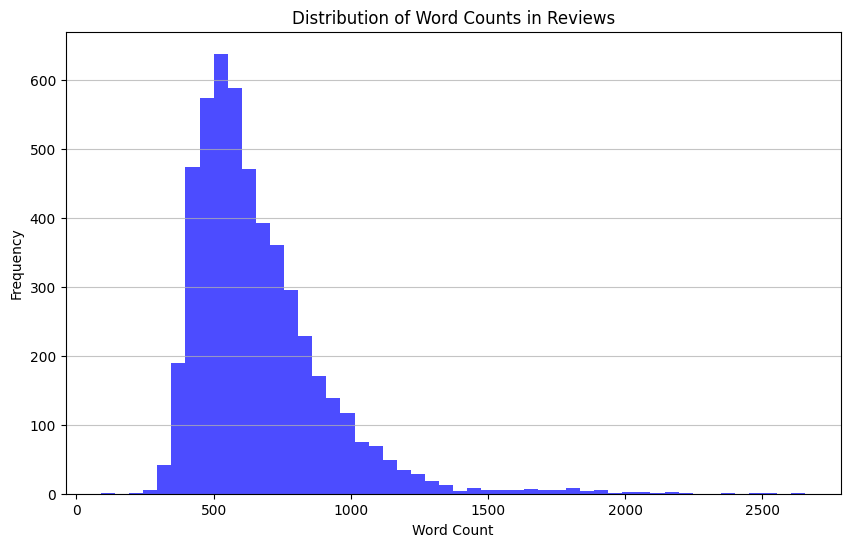

In [32]:
# Check the distribution of word counts
plt.figure(figsize=(10, 6))
plt.hist(filtered_df['word_count'], bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Word Counts in Reviews')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

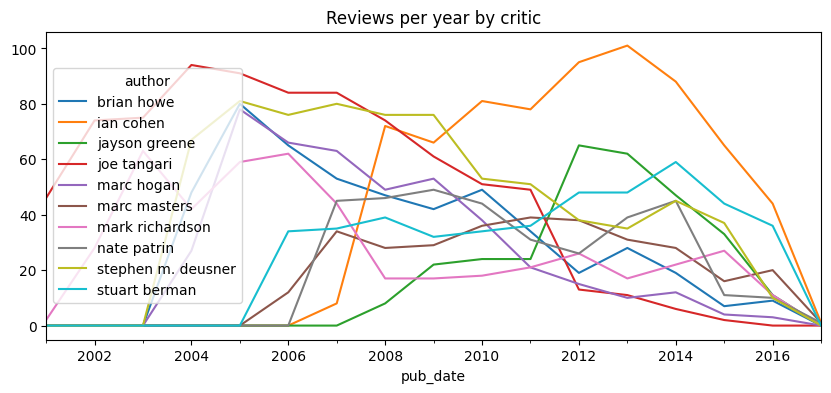

In [33]:
# make sure it's datetime
filtered_df['pub_date'] = pd.to_datetime(filtered_df['pub_date'])

# set the index once
df = filtered_df.set_index('pub_date')

# group by year *and* author at the same time, then unstack authors
annual_counts = (
    df
    .groupby([pd.Grouper(freq='YE'), 'author'])['content']
    .size()
    .unstack(fill_value=0)
)

# now the index is a DatetimeIndex of year-ends
annual_counts.plot(figsize=(10,4))
plt.title('Reviews per year by critic')
plt.show()

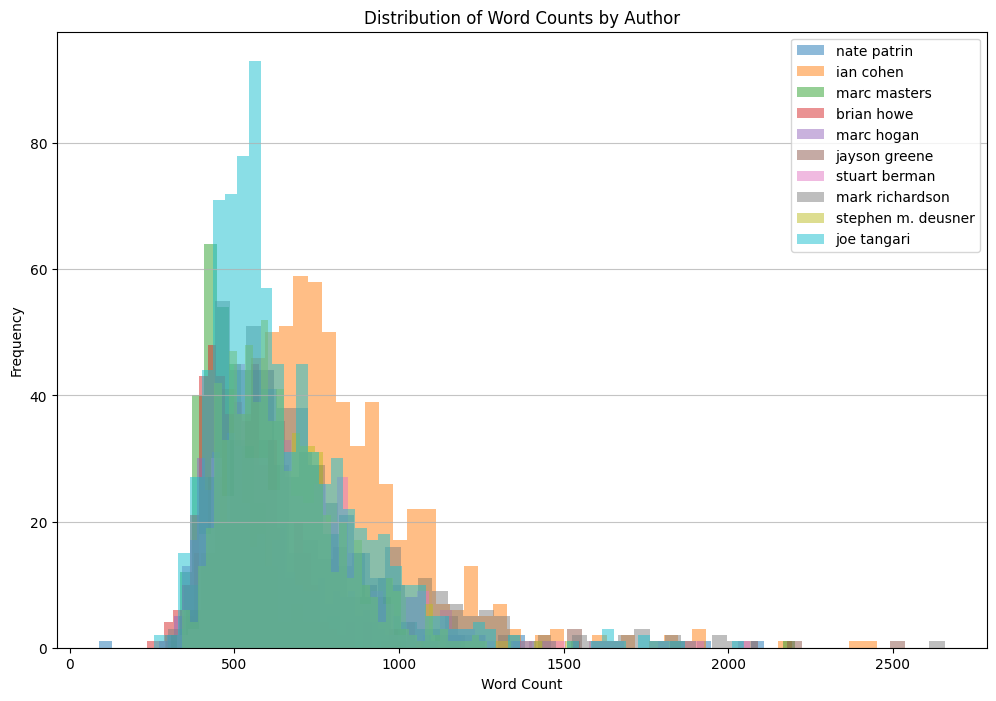

In [34]:
filtered_df.groupby('author')['word_count'].agg(['mean', 'std', 'min', 'max']).sort_values('mean', ascending=False).head(10)
# Check the distribution of word counts for each author
plt.figure(figsize=(12, 8))
for author in filtered_df.author.unique():
    plt.hist(filtered_df[filtered_df['author'] == author]['word_count'], bins=50, alpha=0.5, label=author)
plt.title('Distribution of Word Counts by Author')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='y', alpha=0.75)
plt.show()

## Train-Val-Test split

Because critics began writing in different years, we adopted a per-author chronological split: for each critic, the earliest 60 % of their reviews form train, the next 20 % validation, and the most recent 20 % test. This retains forward-in-time evaluation while ensuring every author appears in all splits.

In [35]:
# Per-author chronological split  (60 / 20 / 20)
train_idx, val_idx, test_idx = [], [], []

for author, sub in filtered_df.groupby('author'):
    sub = sub.sort_values('pub_date')
    n   = len(sub)
    n1, n2 = int(0.6*n), int(0.8*n)
    train_idx += sub.index[:n1].tolist()
    val_idx   += sub.index[n1:n2].tolist()
    test_idx  += sub.index[n2:].tolist()

train_df = filtered_df.loc[train_idx].reset_index(drop=True)
val_df   = filtered_df.loc[val_idx].reset_index(drop=True)
test_df  = filtered_df.loc[test_idx].reset_index(drop=True)

print({s: len(d) for s, d in
       [('train', train_df), ('val', val_df), ('test', test_df)]})
print(train_df['author'].value_counts().head(10))
print(val_df['author'].value_counts().head(10))
print(test_df['author'].value_counts().head(10))
# We have enough data for each split

{'train': 3030, 'val': 1010, 'test': 1014}
author
joe tangari           489
stephen m. deusner    435
ian cohen             419
brian howe            300
mark richardson       285
stuart berman         267
marc hogan            263
nate patrin           208
marc masters          187
jayson greene         177
Name: count, dtype: int64
author
joe tangari           163
stephen m. deusner    145
ian cohen             140
brian howe            100
mark richardson        95
stuart berman          89
marc hogan             88
nate patrin            69
marc masters           62
jayson greene          59
Name: count, dtype: int64
author
joe tangari           163
stephen m. deusner    145
ian cohen             140
brian howe            100
mark richardson        96
stuart berman          89
marc hogan             88
nate patrin            70
marc masters           63
jayson greene          60
Name: count, dtype: int64


In [36]:
y_train = train_df['author'].reset_index(drop=True)
y_val   = val_df['author'].reset_index(drop=True)
y_test  = test_df['author'].reset_index(drop=True)

## Feature Engineering

### Stylometric embeddings

#### Character n-gram TF-IDF

In [37]:
# Character 3-5-gram TF-IDF
tfidf_char = TfidfVectorizer(analyzer='char', ngram_range=(3,5),
                      min_df=5, max_features=50_000)

X_tfidf_char_train = tfidf_char.fit_transform(train_df['content'])
X_tfidf_char_val   = tfidf_char.transform(val_df['content'])
X_tfidf_char_test  = tfidf_char.transform(test_df['content'])

# SVD for t-SNE & faster classifiers
svd = TruncatedSVD(300, random_state=42).fit(X_tfidf_char_train)
X_tfidf_char_train_red = svd.transform(X_tfidf_char_train)
X_tfidf_char_val_red   = svd.transform(X_tfidf_char_val)
X_tfidf_char_test_red  = svd.transform(X_tfidf_char_test)

#### Word n-gram TF-IDF

In [38]:
# Word uni-bigram TF-IDF
tfidf_word_uni_bigram = TfidfVectorizer(analyzer='word', ngram_range=(1,2),
                           min_df=3, max_features=40_000, sublinear_tf=True)

X_tfidf_word_train = tfidf_word_uni_bigram.fit_transform(train_df['content'])
X_tfidf_word_val   = tfidf_word_uni_bigram.transform(val_df['content'])
X_tfidf_word_test  = tfidf_word_uni_bigram.transform(test_df['content'])

# SVD for t-SNE & faster classifiers
svd = TruncatedSVD(300, random_state=42).fit(X_tfidf_word_train)
X_tfidf_word_train_red = svd.transform(X_tfidf_word_train)
X_tfidf_word_val_red   = svd.transform(X_tfidf_word_val)
X_tfidf_word_test_red  = svd.transform(X_tfidf_word_test)

#### Character n-gram Count Vectorizer

In [39]:
# Character 3-5-gram CountVectorizer
count_char = CountVectorizer(analyzer='char', ngram_range=(3,5),
                        min_df=5, max_features=50_000)

X_count_char_train = count_char.fit_transform(train_df['content'])
X_count_char_val   = count_char.transform(val_df['content'])
X_count_char_test  = count_char.transform(test_df['content'])

# SVD for t-SNE & faster classifiers
svd = TruncatedSVD(300, random_state=42).fit(X_count_char_train)
X_count_char_train_red = svd.transform(X_count_char_train)
X_count_char_val_red   = svd.transform(X_count_char_val)
X_count_char_test_red  = svd.transform(X_count_char_test)

### Semantic embeddings

In [40]:
# Semantic features (Sentence-BERT)
SentenceTransformer_ = SentenceTransformer('all-MiniLM-L6-v2')

X_st_train = SentenceTransformer_.encode(train_df['content'], batch_size=64, show_progress_bar=True)
X_st_val = SentenceTransformer_.encode(val_df['content'], batch_size=64, show_progress_bar=True)
X_st_test = SentenceTransformer_.encode(test_df['content'], batch_size=64, show_progress_bar=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/48 [00:00<?, ?it/s]

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

## Model Selection

In [41]:
# Configuration
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scorers = {
    'acc': make_scorer(accuracy_score),
    'f1m': make_scorer(f1_score, average='macro')
}

# Define models to test
nb_char = MultinomialNB(alpha=0.5)
logreg_tfidf_char = LogisticRegression(max_iter=2000, n_jobs=-1, class_weight='balanced')
logreg_count_char = LogisticRegression(max_iter=2000, n_jobs=-1, class_weight='balanced')
logreg_tfidf_word = LogisticRegression(max_iter=2000, n_jobs=-1, class_weight='balanced')
logreg_sentt = LogisticRegression(max_iter=2000, n_jobs=-1, class_weight='balanced')
svm_tfidf_word = LinearSVC(class_weight='balanced', max_iter=5000, random_state=42)
svm_count_char = LinearSVC(class_weight='balanced', max_iter=5000, random_state=42)
# Define pipelines to test
feature_sets = [
    ("Naive Bayes", "Char Count (3-5)", nb_char,
     X_count_char_train, X_count_char_val),
    ("Logistic Regression", "Char TF-IDF (3-5)", logreg_tfidf_char,
     X_tfidf_char_train, X_tfidf_char_val),
    ("Logistic Regression", "Char Count (3-5)", logreg_count_char,
     X_count_char_train, X_count_char_val),
    ("Logistic Regression", "Word TF-IDF (1-2)", logreg_tfidf_word,
     X_tfidf_word_train, X_tfidf_word_val),
    ("Linear SVM", "Word TF-IDF (1-2)", svm_tfidf_word,
     X_tfidf_word_train, X_tfidf_word_val),
    ("Linear SVM", "Char Count (3-5)", svm_count_char,
     X_count_char_train, X_count_char_val),
    ("Logistic Regression", "Mini-LM Embeddings", logreg_sentt,
     X_st_train, X_st_val)
]

In [ ]:
# Evaluation function
def evaluate_train_set(model, X_train, y_train, X_val, y_val, cv=cv):
    """Return fitted model plus mean±std for accuracy and macro-F1."""
    cv_res = cross_validate(model, X_train, y_train,
                            cv=cv, scoring=scorers, return_train_score=False)

    acc_mean = cv_res['test_acc'].mean()
    acc_std  = cv_res['test_acc'].std()
    f1_mean  = cv_res['test_f1m'].mean()
    f1_std   = cv_res['test_f1m'].std()

    print(f"5-fold CV - acc: {acc_mean:.3f} ± {acc_std:.3f} | "
          f"macro-F1: {f1_mean:.3f} ± {f1_std:.3f}")

    model.fit(X_train, y_train)
    val_pred = model.predict(X_val)

    val_acc = accuracy_score(y_val, val_pred)
    val_f1  = f1_score(y_val, val_pred, average='macro')
    print(f"{model} Validation - acc: {val_acc:.3f} | macro-F1: {val_f1:.3f}")

    return (acc_mean, acc_std, f1_mean, f1_std), (val_acc, val_f1)

def update_leaderboard(leaderboard, model_name, vectorizer_name, metrics):
    """
    Adds a new row of metrics to the leaderboard DataFrame.

    Parameters:
    - leaderboard (pd.DataFrame): The current leaderboard.
    - model_name (str): Name of the model used.
    - vectorizer_name (str): Name of the vectorization technique.
    - metrics (tuple): Tuple in the form ((acc_mean, acc_std, f1_mean, f1_std), (val_acc, val_f1))

    Returns:
    - pd.DataFrame: Updated leaderboard.
    """
    (acc_mean, acc_std, f1_mean, f1_std), (val_acc, val_f1) = metrics

    new_entry = {
        'Model': model_name,
        'Vectorizer': vectorizer_name,
        'Acc_Mean': acc_mean,
        'Acc_Std': acc_std,
        'F1_Mean': f1_mean,
        'F1_Std': f1_std,
        'Val_Acc': val_acc,
        'Val_F1': val_f1
    }

    leaderboard = pd.concat([leaderboard, pd.DataFrame([new_entry])], ignore_index=True)
    return leaderboard

In [43]:
# Initialize leaderboard
leaderboard = pd.DataFrame(columns=[
    'Model', 'Vectorizer', 'Acc_Mean', 'Acc_Std', 'F1_Mean', 'F1_Std', 'Val_Acc', 'Val_F1'
])

# Loop through each combination
for model_name, vect_name, model_obj, X_tr, X_va in feature_sets:
    metrics = evaluate_train_set(
        model=model_obj,
        X_train=X_tr, y_train=y_train,
        X_val=X_va, y_val=y_val
    )
    leaderboard = update_leaderboard(
        leaderboard, model_name, vect_name, metrics
    )

5-fold CV – acc: 0.955 ± 0.010 | macro-F1: 0.954 ± 0.011
MultinomialNB(alpha=0.5) Validation – acc: 0.939 | macro-F1: 0.936


<ipython-input-42-815c2c90f43a>:50: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  leaderboard = pd.concat([leaderboard, pd.DataFrame([new_entry])], ignore_index=True)


5-fold CV – acc: 0.949 ± 0.013 | macro-F1: 0.948 ± 0.014
LogisticRegression(class_weight='balanced', max_iter=2000, n_jobs=-1) Validation – acc: 0.921 | macro-F1: 0.920
5-fold CV – acc: 0.966 ± 0.011 | macro-F1: 0.965 ± 0.012
LogisticRegression(class_weight='balanced', max_iter=2000, n_jobs=-1) Validation – acc: 0.949 | macro-F1: 0.947
5-fold CV – acc: 0.973 ± 0.005 | macro-F1: 0.972 ± 0.007
LogisticRegression(class_weight='balanced', max_iter=2000, n_jobs=-1) Validation – acc: 0.960 | macro-F1: 0.959
5-fold CV – acc: 0.990 ± 0.005 | macro-F1: 0.989 ± 0.007
LinearSVC(class_weight='balanced', max_iter=5000, random_state=42) Validation – acc: 0.987 | macro-F1: 0.987
5-fold CV – acc: 0.972 ± 0.008 | macro-F1: 0.972 ± 0.008
LinearSVC(class_weight='balanced', max_iter=5000, random_state=42) Validation – acc: 0.961 | macro-F1: 0.960
5-fold CV – acc: 0.456 ± 0.027 | macro-F1: 0.452 ± 0.026
LogisticRegression(class_weight='balanced', max_iter=2000, n_jobs=-1) Validation – acc: 0.440 | macro-F1

In [44]:
# Sort by best validation F1 (or any other metric)
leaderboard = leaderboard.sort_values('Val_F1', ascending=False).reset_index(drop=True)

leaderboard

,Model,Vectorizer,Acc_Mean,Acc_Std,F1_Mean,F1_Std,Val_Acc,Val_F1
0,Linear SVM,Word TF-IDF (1-2),0.989769,0.005463,0.988613,0.007063,0.987129,0.987059
1,Linear SVM,Char Count (3-5),0.971947,0.007879,0.971520,0.008437,0.961386,0.959572
2,Logistic Regression,Word TF-IDF (1-2),0.973267,0.005362,0.971883,0.006779,0.960396,0.958597
3,Logistic Regression,Char Count (3-5),0.966007,0.010571,0.964826,0.011973,0.948515,0.946816
4,Naive Bayes,Char Count (3-5),0.955446,0.009956,0.954343,0.010859,0.938614,0.935518
5,Logistic Regression,Char TF-IDF (3-5),0.949175,0.013341,0.948478,0.013697,0.920792,0.920354
6,Logistic Regression,Mini-LM Embeddings,0.456436,0.026824,0.451974,0.025541,0.439604,0.427619


Bigrams +(SVM) deliver near-perfect author attribution—stylistic word choice and collocations are highly distinctive.

Character counts remain a robust stylistic baseline, but linear models beat Naive Bayes once sample size grows.

Off-the-shelf sentence embeddings (Mini-LM) capture topic, not writer fingerprint; performance collapses to ≈ 45 %.

We also evaluated NB with char-TFIDF and word-TFIDF, but both gave F1 < 0.35 on the validation set and were therefore not competitive, thus discarded from model selection.

## Final Predictions

In [45]:
def evaluate_predictions(y_true, y_pred, labels=None, figsize=(8,6)):
    # Compute metrics
    accuracy = accuracy_score(y_true, y_pred)
    f1_macro = f1_score(y_true, y_pred, average='macro')
    print(f"Accuracy: {accuracy:.3f}")
    print(f"Macro-F1: {f1_macro:.3f}\n")

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    if labels is None:
        labels = sorted(set(y_true))

    # Plot
    fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(cm, interpolation='nearest', cmap='Blues')
    cbar = fig.colorbar(im, ax=ax)
    cbar.ax.set_ylabel('Count', rotation=-90, va='bottom')

    # Tick labels
    ax.set_xticks(range(len(labels)))
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.set_yticks(range(len(labels)))
    ax.set_yticklabels(labels)

    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')
    ax.set_title('Confusion Matrix')

    # Annotate cells
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > thresh else "black"
        ax.text(j, i, format(cm[i, j], 'd'),
                ha='center', va='center', color=color)

    plt.tight_layout()
    plt.show()

    return {
        'accuracy': accuracy,
        'f1_macro': f1_macro,
        'confusion_matrix': cm
    }

In [46]:
from scipy.sparse import vstack
# Our best performer on validation set was Tfidf Word(1,2)-gram Vectorizer with Linear Suppor Vector Machine.
# Now we train on train+dev to make our predictions for the test data

X_full = vstack([X_tfidf_word_train, X_tfidf_word_val])
y_full = np.concatenate([y_train, y_val])

svm_tfidf_word.fit(X_full, y_full)

LinearSVC(class_weight='balanced', max_iter=5000, random_state=42)

In [51]:
y_pred = svm_tfidf_word.predict(X_tfidf_word_test)

Accuracy: 0.982
Macro-F1: 0.982



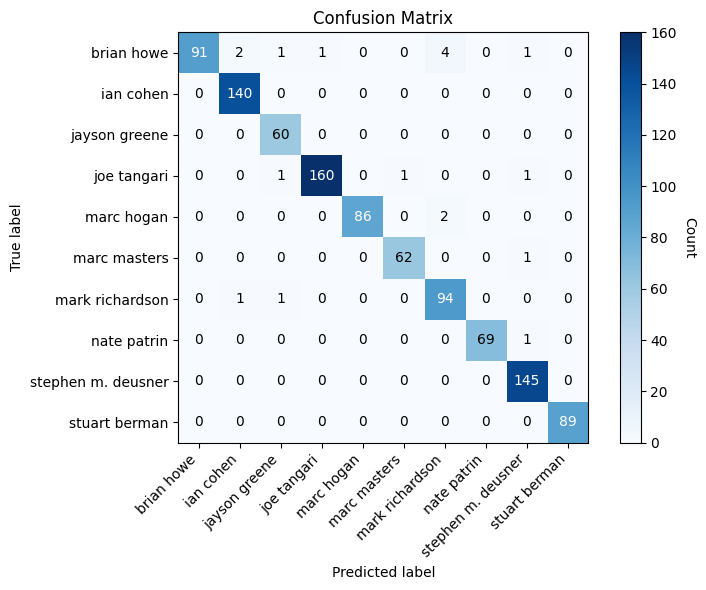

{'accuracy': 0.9822485207100592,
 'f1_macro': 0.9816559669464888,
 'confusion_matrix': array([[ 91,   2,   1,   1,   0,   0,   4,   0,   1,   0],
        [  0, 140,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,  60,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   1, 160,   0,   1,   0,   0,   1,   0],
        [  0,   0,   0,   0,  86,   0,   2,   0,   0,   0],
        [  0,   0,   0,   0,   0,  62,   0,   0,   1,   0],
        [  0,   1,   1,   0,   0,   0,  94,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,  69,   1,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0, 145,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,  89]])}

In [53]:
evaluate_predictions(y_true=y_test, y_pred=y_pred)

The high accuracy and macro F1-score suggest the model generalizes well across authors, with good performance even on less represented classes. The confusion matrix indicates low inter-author confusion, reinforcing the idea that distinct reviewers have unique and learnable stylistic patterns. This aligns with our project's aim to discover stylistic "fingerprints" in music reviews.


Saving the model

In [54]:
import joblib
models_dir = "../vectorizer_and_classifier"
os.makedirs(models_dir, exist_ok=True)
joblib.dump(count_char, f"{models_dir}/word_tfidf_vect.pkl")
joblib.dump(svm_count_char, f"{models_dir}/svm_word_tfidf.pkl")

['vectorizer_and_classifier/svm_word_tfidf.pkl']

## Author Style Visualizations

In [55]:
# Author-Style Visualizations
tsne   = TSNE(n_components=2, perplexity=50, metric='cosine',
              init='pca', learning_rate='auto', random_state=42)
palette = dict(zip(
    y_train.unique(),                      # list of author strings
    sns.color_palette('husl', y_train.nunique()) # as many colours as authors
))

def plot_tSNE(X, y, embedding):

  xy = tsne.fit_transform(X)
  plt.figure(figsize=(8, 8))
  sns.scatterplot(x=xy[:,0], y=xy[:,1],
                  #hue=authors.cat.codes,
                  hue=y,
                  palette=palette,
                  #palette=sns.color_palette('husl', authors.nunique()),
                  alpha=0.6, s=20, linewidth=0)
  plt.legend(title='Author', bbox_to_anchor=(1.05, 1), loc='upper left')
  plt.title(f't-SNE of {embedding} embeddings')
  plt.axis('off');

### t-SNE with Count char-count embeddings

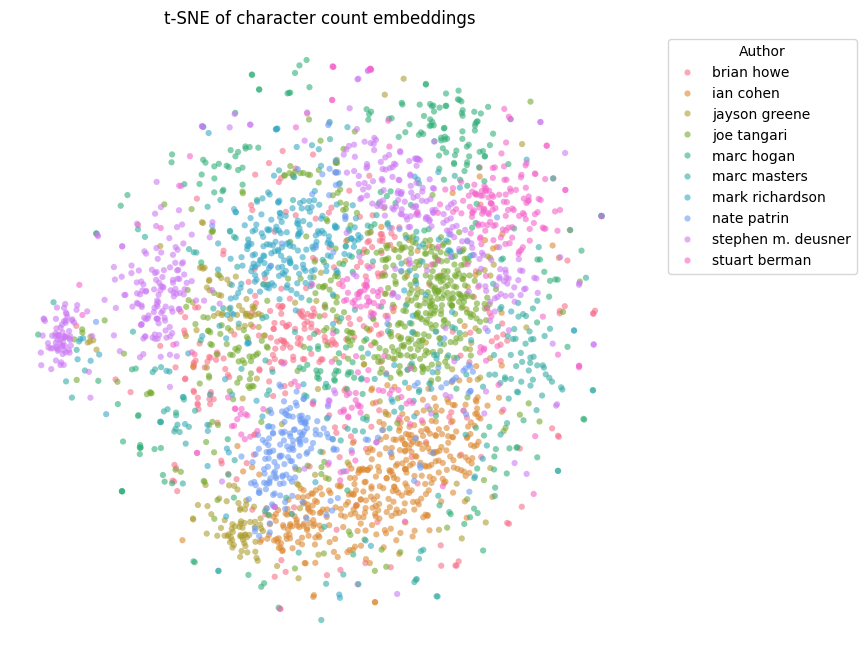

In [56]:
# t-SNE with count character embeddings
plot_tSNE(X=X_count_char_train_red, y=y_train, embedding="character count")

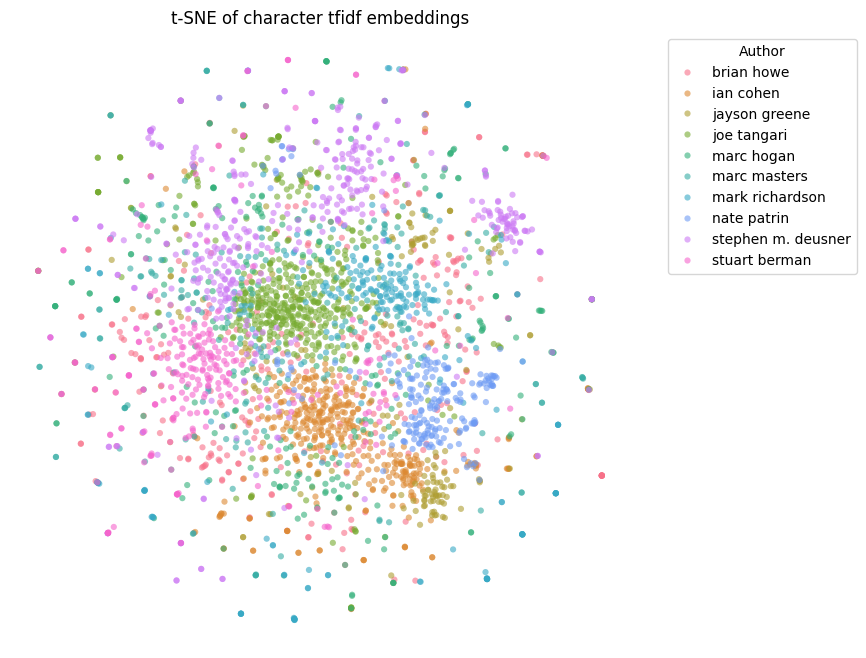

In [57]:
# t-SNE with tfidf character embeddings
plot_tSNE(X=X_tfidf_char_train_red, y=y_train, embedding="character tfidf")

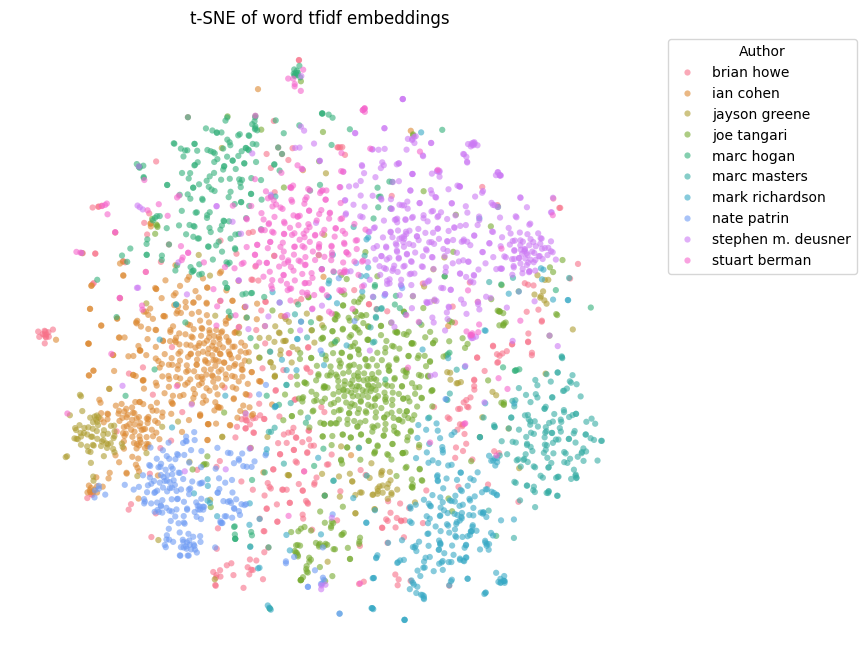

In [58]:
# t-SNE with tfidf word embeddings
plot_tSNE(X=X_tfidf_word_train_red, y=y_train, embedding="word tfidf")

### Correlation Between Authors

In [59]:
authors = y_train.unique()
author_means = {a: X_tfidf_word_train_red[y_train == a].mean(axis=0) for a in authors}

# Compute distance matrix (Euclidean)
distance_matrix = pd.DataFrame(
    [[np.linalg.norm(author_means[a1] - author_means[a2]) for a2 in authors] for a1 in authors],
    index=authors, columns=authors
)

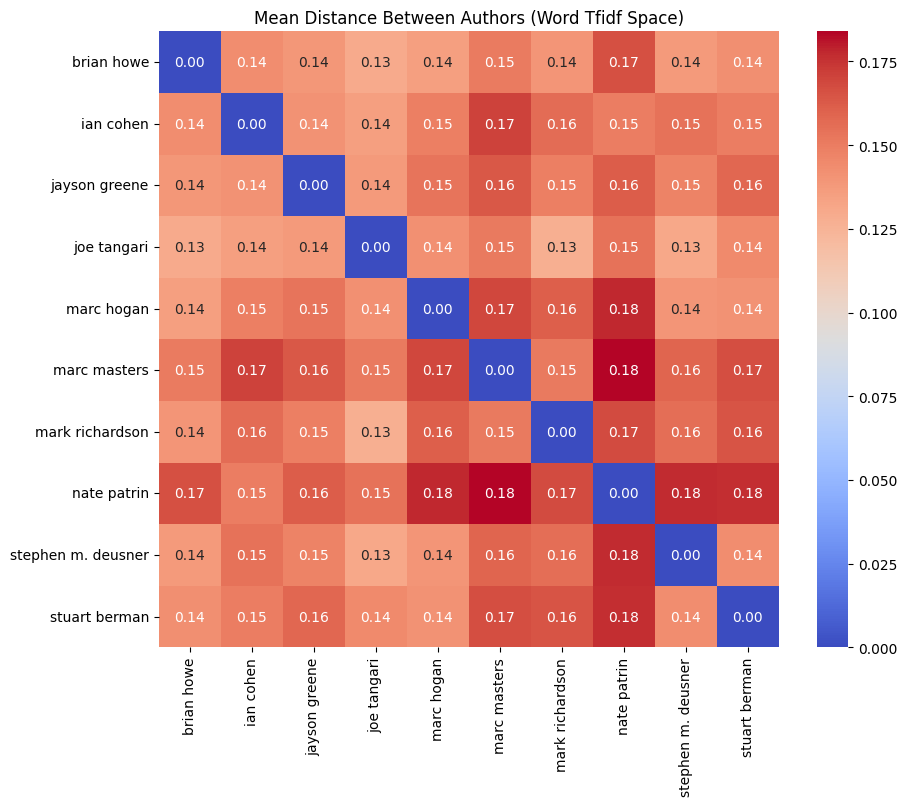

In [60]:
plt.figure(figsize=(10, 8))
sns.heatmap(distance_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Mean Distance Between Authors (Word Tfidf Space)")
plt.show()

### Interpretability

In [61]:
coefs = svm_tfidf_word.coef_
ngrams = tfidf_word_uni_bigram.get_feature_names_out()

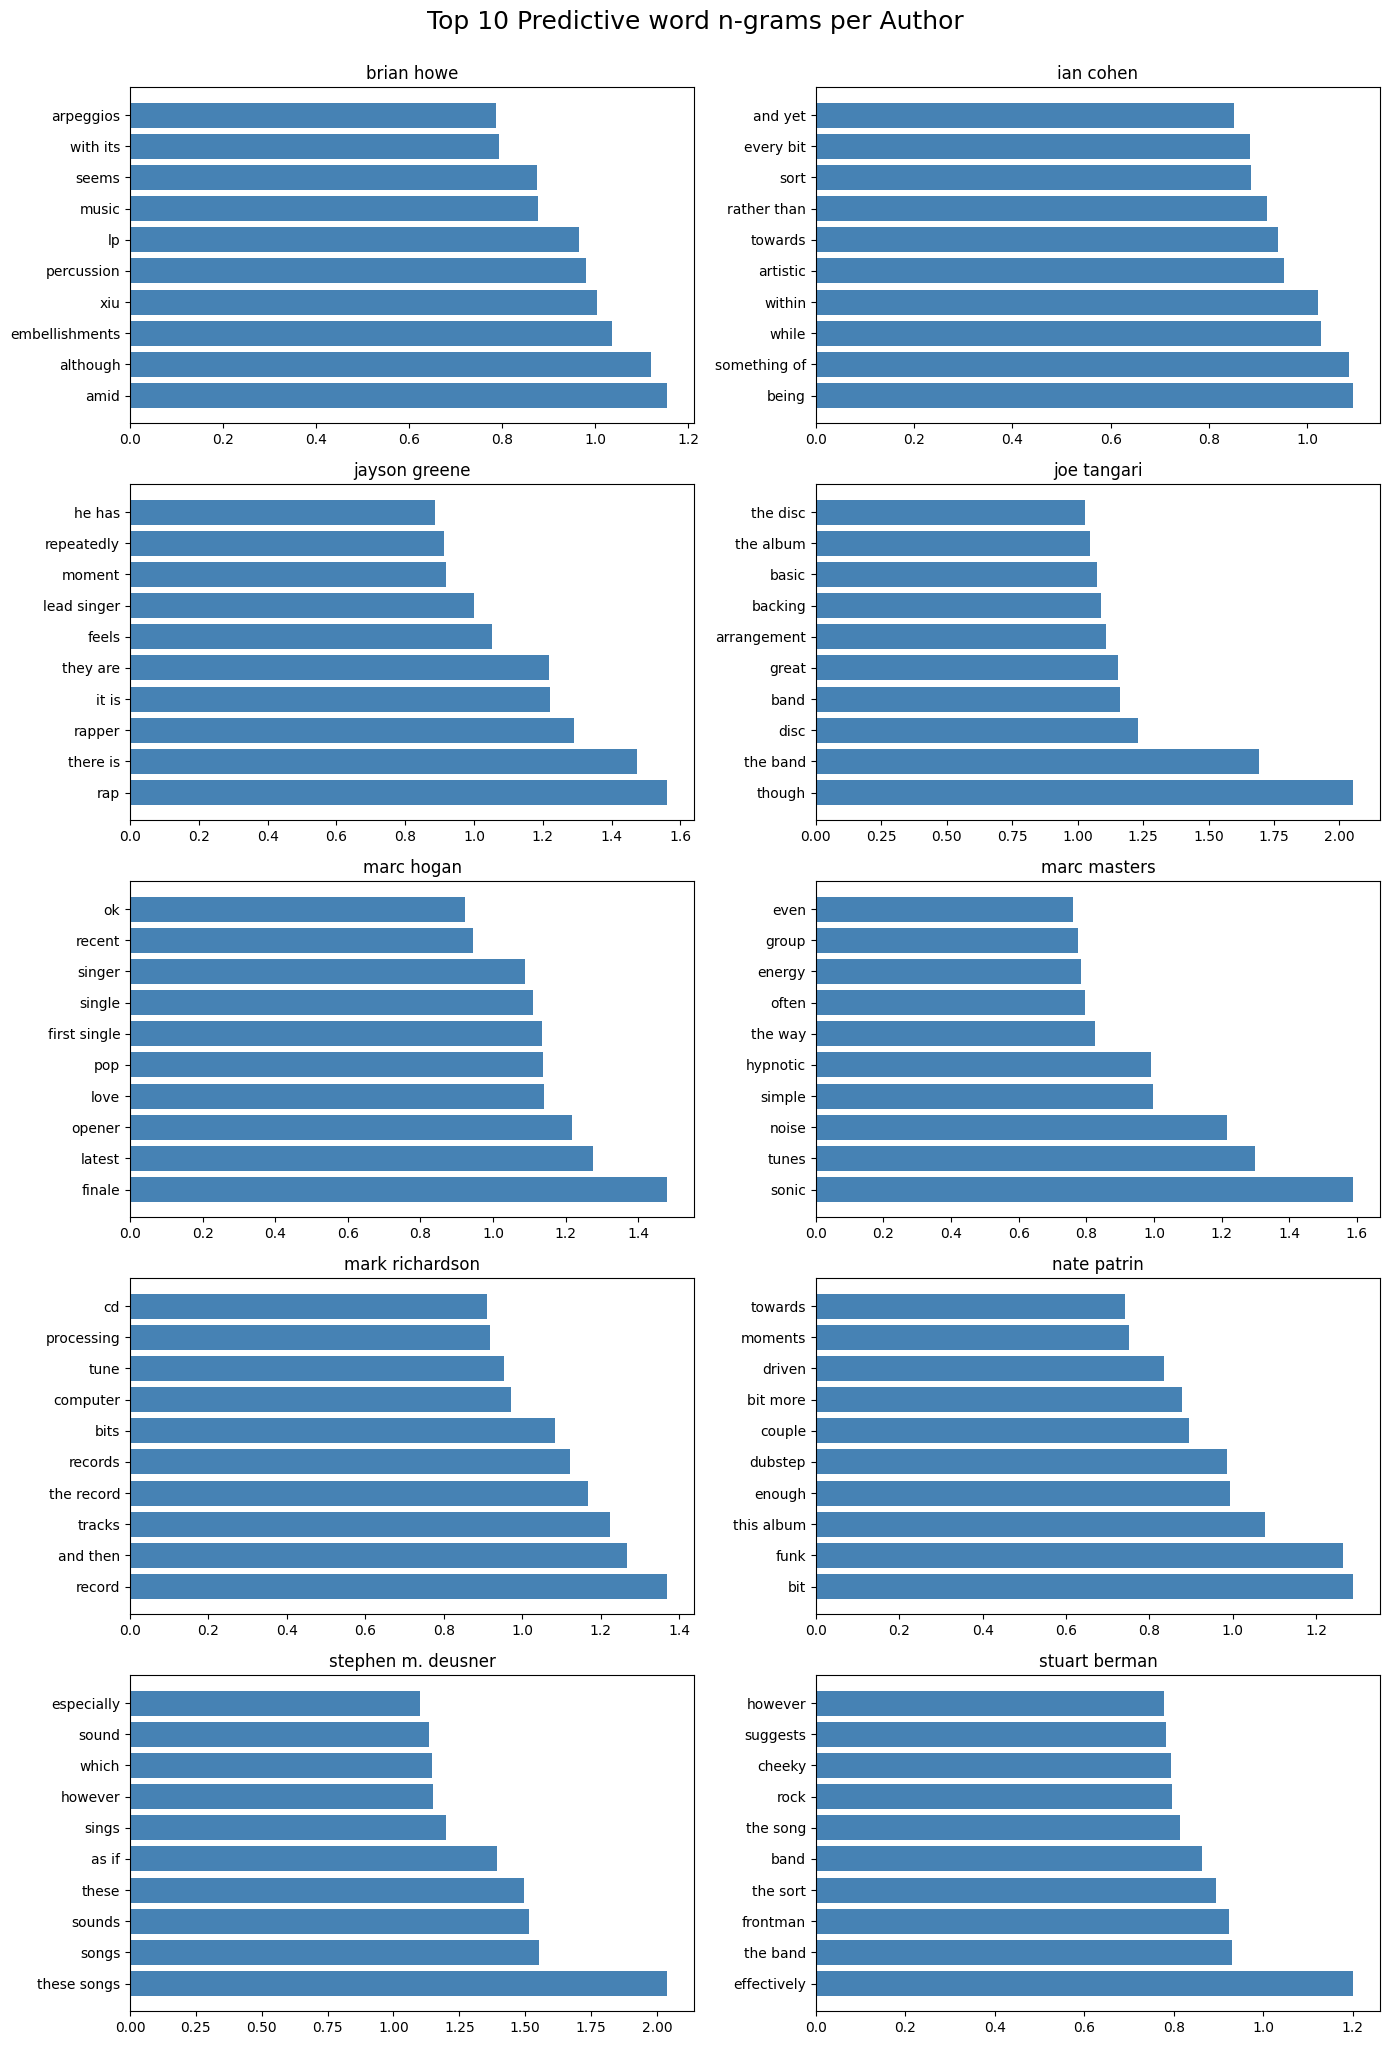

In [62]:
# Plot top 10 n-grams for each author
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(14, 20))
axes = axes.flatten()

for i, author in enumerate(authors):
    top_idx = np.argsort(coefs[i])[::-1][:10]
    top_vals = coefs[i][top_idx]
    top_labels = ngrams[top_idx]

    axes[i].barh(top_labels[::-1], top_vals[::-1], color='steelblue')
    axes[i].set_title(author)
    axes[i].invert_yaxis()

plt.tight_layout()
plt.suptitle("Top 10 Predictive word n-grams per Author", fontsize=18, y=1.02)
plt.show()